In [1]:
import os

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams['figure.dpi'] = 120

from shmex.local import localify
from shmex.shm_zoo import long_name_of_short_name, fix_parameter_count
figures_dir = localify('FIGURES_DIR')

# default_font_size = plt.rcParams['font.size']
# plt.rcParams.update({'font.size': default_font_size * 1.4})

Using Metal Performance Shaders


In [2]:
compare_df = pd.read_csv("../train/_ignore/human_model_compare.csv")
#compare_df = pd.read_csv("../train/_ignore/prod_model_compare.csv")

# drop rows where crepe_basename is s5f and put them in a separate df called fixed_df
literature_models = ["s5f","cnn_ind_med-shmoof_small"]
fixed_df = compare_df[compare_df["crepe_basename"].isin(literature_models)]
compare_df = compare_df[~compare_df["crepe_basename"].isin(literature_models)]

# split crepe_basename on "-", the first entry is the model name and the second entry is the train dataset
compare_df["model"] = compare_df["crepe_basename"].apply(lambda x: x.split("-")[0])
compare_df["train dataset"] = compare_df["crepe_basename"].apply(lambda x: x.split("-")[1])
compare_df["training method"] = compare_df["crepe_basename"].apply(lambda x: x.split("-")[2])
compare_df["seed"] = compare_df["crepe_basename"].apply(lambda x: x.split("-")[3])
compare_df = compare_df.drop(columns=["crepe_prefix", "crepe_basename"])
compare_df = compare_df.rename(columns={"dataset_name": "test dataset"})
compare_df = compare_df.sort_values(by=["train dataset", "model"]).reset_index(drop=True)

compare_df["model"].unique()
#compare_df

array(['cnn_ind_lrg', 'cnn_ind_med', 'cnn_joi_lrg', 'fivemer', 'rsshmoof'],
      dtype=object)

In [3]:
df = compare_df.copy()

# drop any rows where model matches 4k or 8k
df = df[~df.model.str.contains("4k")]
df = df[~df.model.str.contains("8k")]

# NOTE restrictions here
#df = df[df["train dataset"] == "shmoof_small"]
df = df[df["test dataset"].str.endswith("_all")]

df["parameter_count"] = df.apply(fix_parameter_count, axis=1)

def create_long_name(row):
    full_name = long_name_of_short_name(row["model"])
    # return f"{full_name} ({row['parameter_count']}) {row['training method']}"
    return f"{full_name} ({row['parameter_count']})"

# Apply the transformation to create the long_name column
df['long_name'] = df.apply(create_long_name, axis=1)

# sort df by parameter count
df = df.sort_values(by="parameter_count", kind="mergesort")
# reverse stable sort by test dataset   
df = df.sort_values(by="test dataset", kind="mergesort")

# extract the rows where "test dataset" is "val_oracleshmoofcnn10k" and put them in a separate df called oracle_df
for (oracle_data, oracle_data_nickname) in [("val_oracleshmoofcnn10k", "shmoof_small"), ("val_oracletangcnn", "val_tangshm")]:
    oracle_df = df[df["test dataset"] == oracle_data]
    df = df[df["test dataset"] != oracle_data]

    # drop all rows where model isn't cnn_joi_lrg
    oracle_df = oracle_df[oracle_df["model"] == "cnn_joi_lrg"]
    oracle_df["test dataset"] = oracle_data_nickname
    oracle_df["long_name"] = "Oracle"

    # append oracle_df to df
    df = pd.concat([df, oracle_df])

test_dataset_mapping = {
    "shmoof_notbig_all": "briney held-out",
    "val_tangshm_all": "tang",
    "val_syn10x25k_all": "synonymous 10x",
}

stat_renaming_dict = {'r-prec': 'R-precision', 'sub_acc': 'substitution accuracy'}

df["long_name"].unique(), df["model"].unique(), df["test dataset"].unique()

(array(['CNN Joined Large (2057)', '5mer (3077)', 'Spisak (3576)',
        'CNN Indep Medium (4539)', 'CNN Indep Large (5931)'], dtype=object),
 array(['cnn_joi_lrg', 'fivemer', 'rsshmoof', 'cnn_ind_med', 'cnn_ind_lrg'],
       dtype=object),
 array(['shmoof_notbig_all', 'val_syn10x25k_all', 'val_tangshm_all'],
       dtype=object))

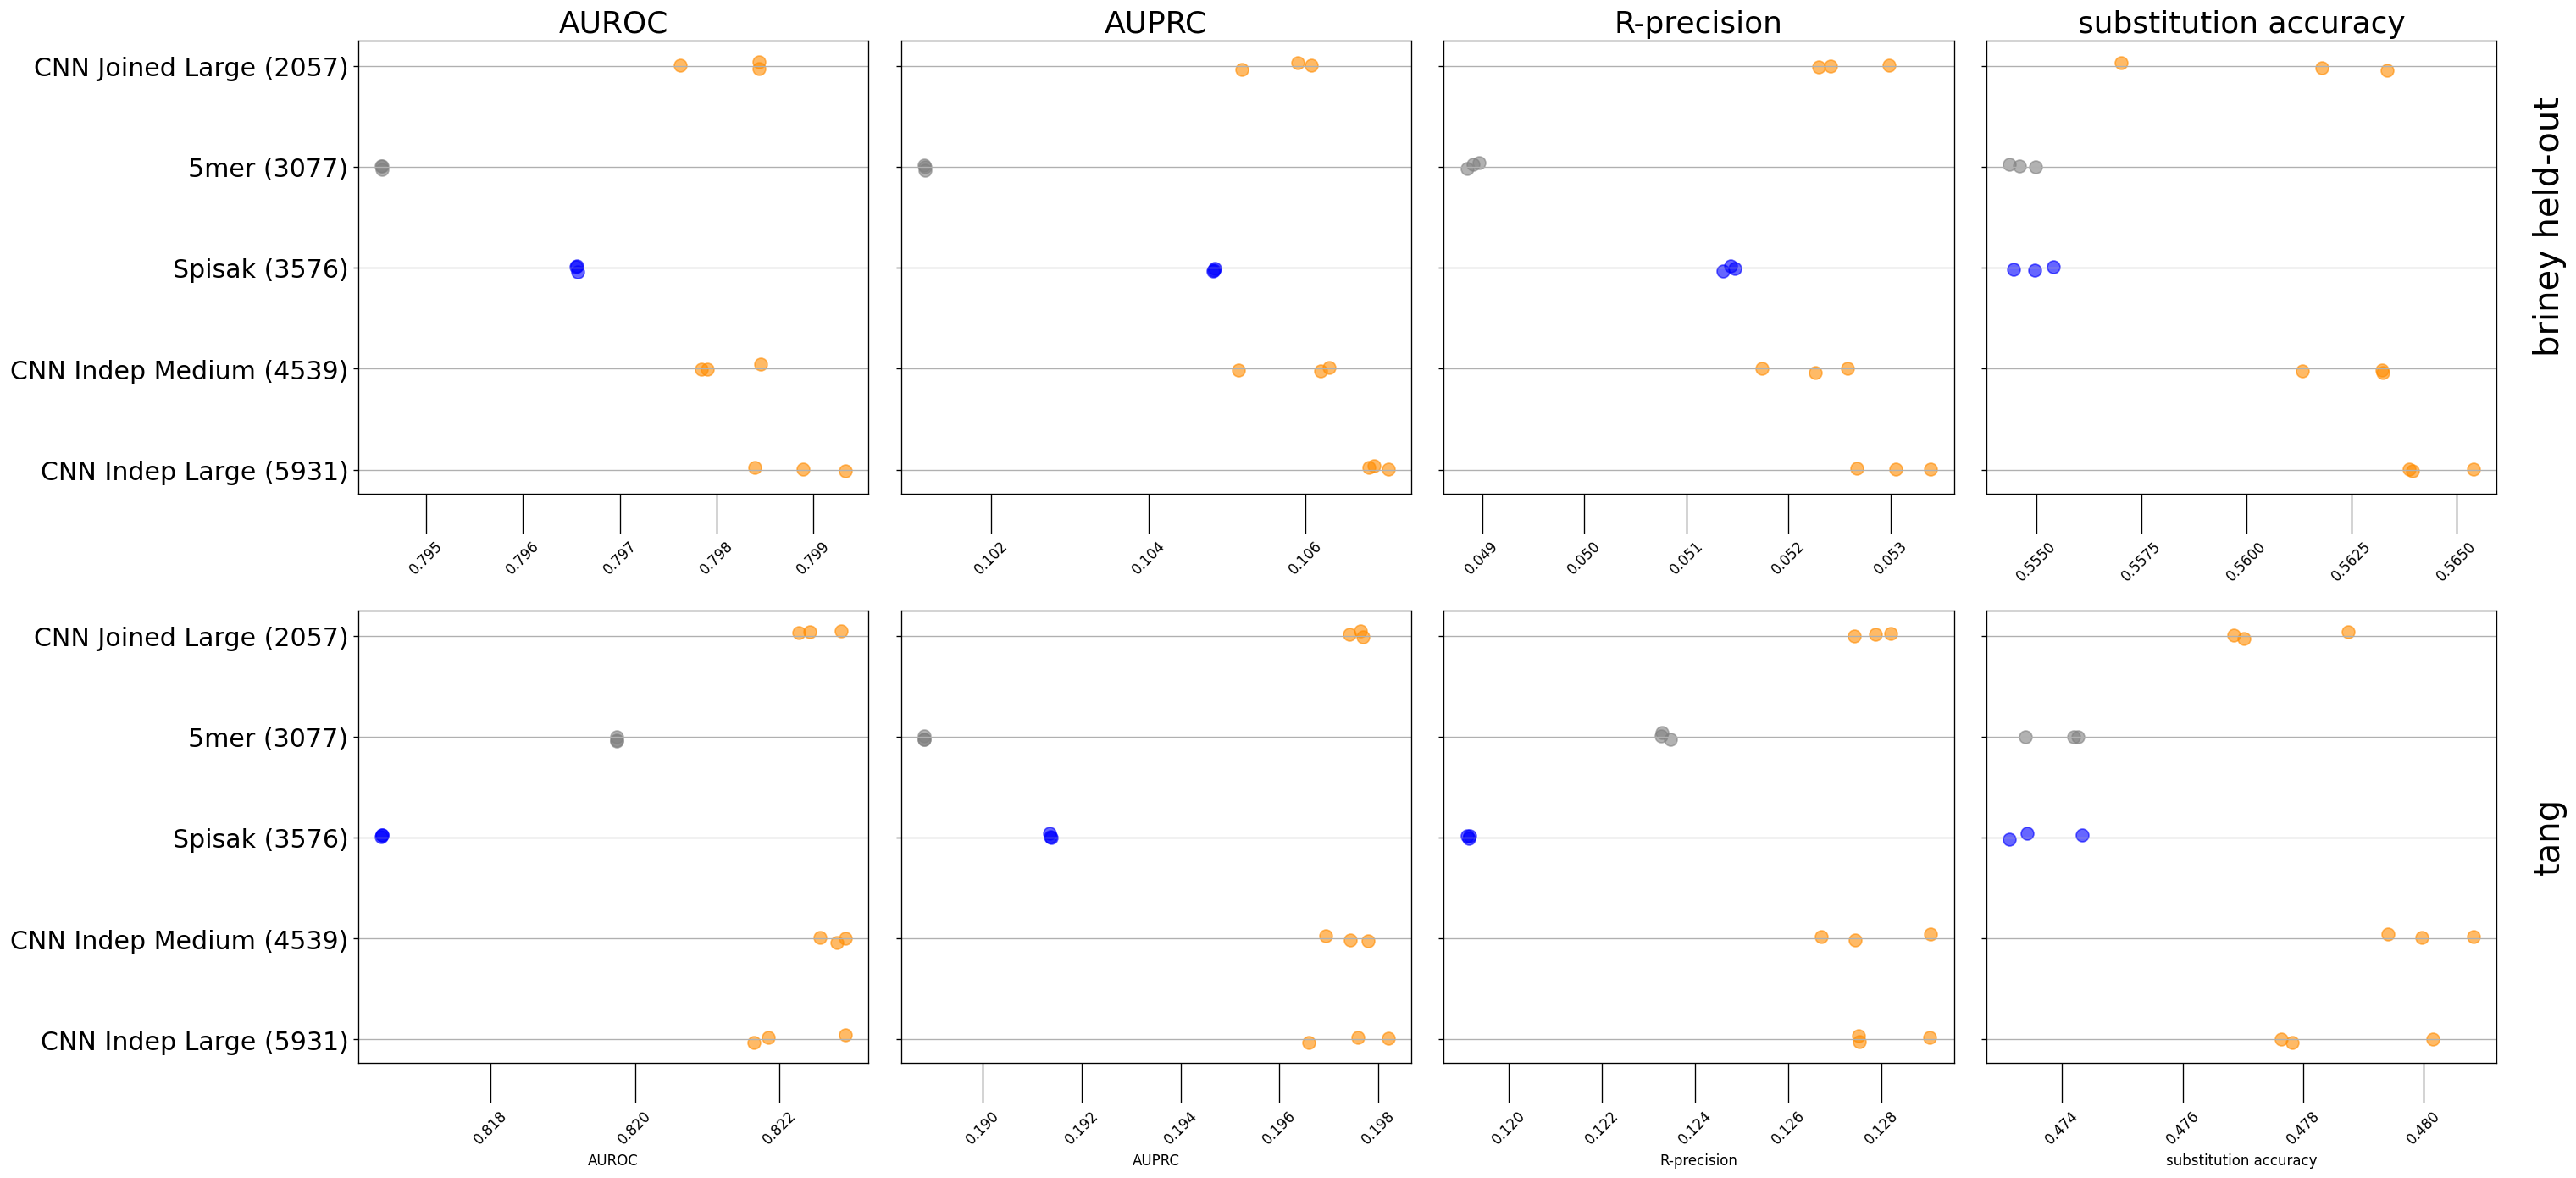

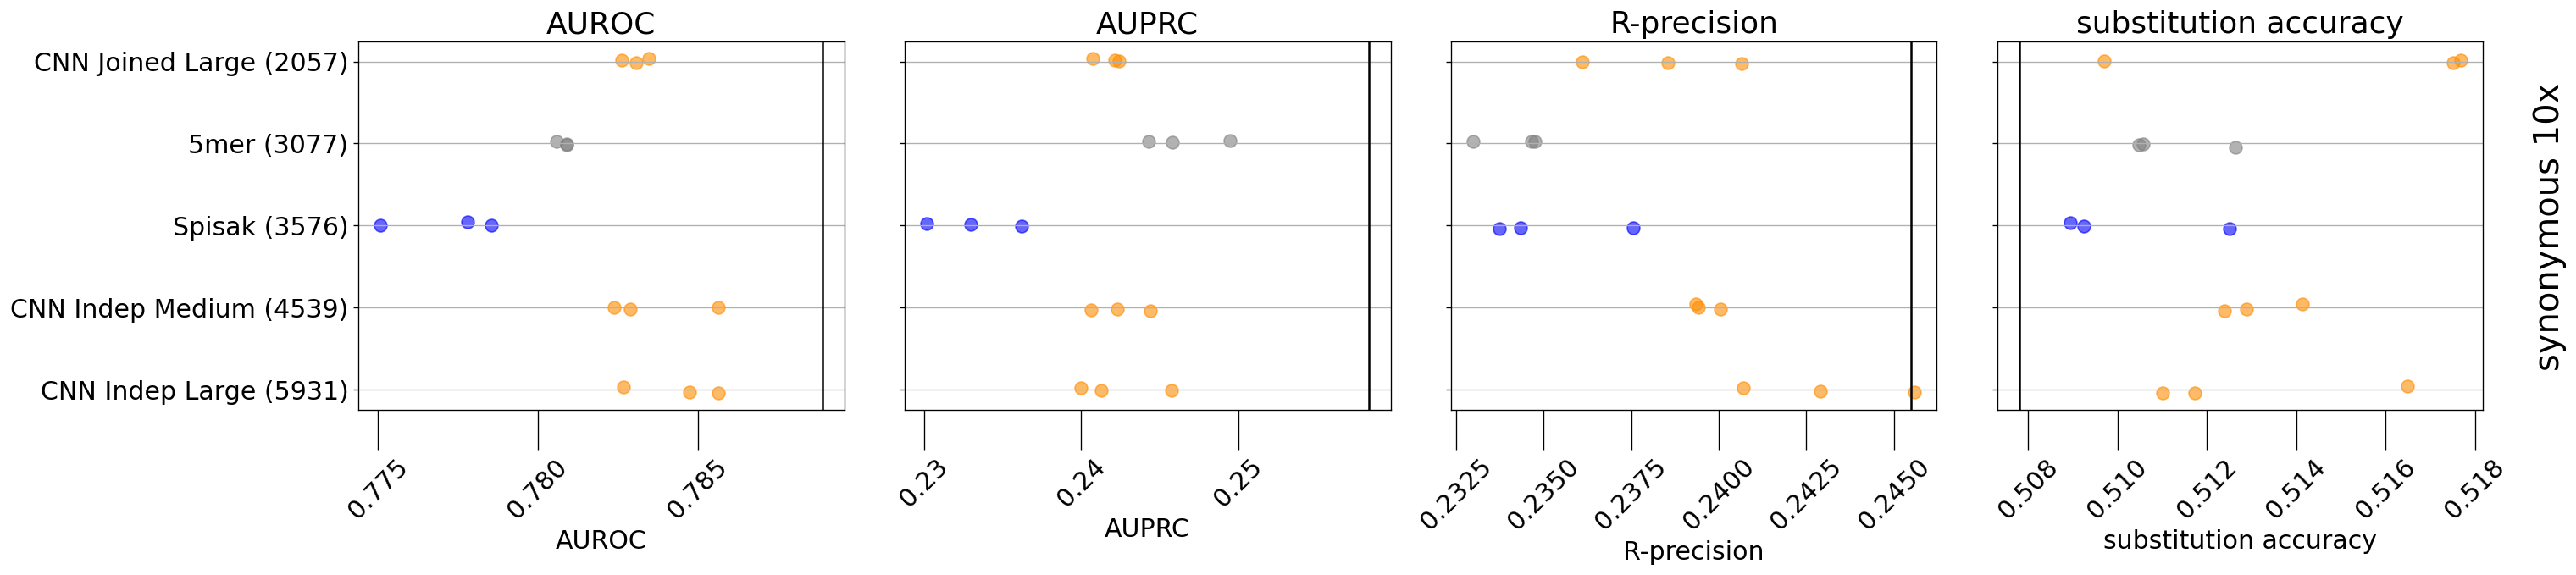

In [4]:
def plot_performance(df, test_datasets=None, filename=None, stats=None, include_reference=False, include_baseline=True, plotting_difference=False):
    baseline_model = "s5f"
    reference_model = "cnn_ind_med-shmoof_small"
    df = df.copy()

    # If stats are not provided, use the default set of statistics
    if stats is None:
        stats = ['AUROC', 'AUPRC', 'r-prec', 'sub_acc', 'overlap', 'mut_pos_ll']

    # If test_datasets are not provided, get all unique test datasets
    if test_datasets is None:
        test_datasets = df['test dataset'].unique()
    else:
        # Check to make sure all provided test_datasets are present in df
        for test_dataset in test_datasets:
            if test_dataset not in df['test dataset'].unique():
                raise ValueError(f"test dataset {test_dataset} not found in df")

    unique_long_names = df['long_name'].unique()[::-1]
    name_to_y = {name: i for i, name in enumerate(unique_long_names)}

    # Setup figure parameters, transposing nrows with ncols
    nrows = len(test_datasets)
    ncols = len(stats)

    jitter_strength = 0.09

    if plotting_difference:
        sharex = True
    else:
        sharex = False

    # Create subplots
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5 * ncols + 5, 6 * nrows), squeeze=False, sharey=True, sharex=sharex)
    plt.rcParams.update({'font.size': 18})

    for row_idx, test_dataset in enumerate(test_datasets):
        # Add test dataset name to the left of the row.
        test_dataset_name = test_dataset_mapping.get(test_dataset, test_dataset)
        fig.text(1.01, (nrows - row_idx - 0.4) / nrows, test_dataset_name, ha='center', va='center', rotation='vertical', fontsize=24)

        # Filter the DataFrame for the current test dataset
        df_filtered = df[df['test dataset'] == test_dataset].copy()

        baseline_values = fixed_df.query("dataset_name == @test_dataset and crepe_basename == @baseline_model").reset_index(drop=True).iloc[0]
        reference_values = fixed_df.query("dataset_name == @test_dataset and crepe_basename == @reference_model").reset_index(drop=True).iloc[0]

        for col_idx, stat in enumerate(stats):
            if not df_filtered.empty:
                df_filtered[stat + '_relative'] = df_filtered[stat] - baseline_values[stat]
                df_filtered = df_filtered.sort_values(by="parameter_count", ascending=False)

                ax = axes[row_idx, col_idx]

                # Plot each point, adding jitter around the assigned y-value
                for i, row in df_filtered.iterrows():
                    y_pos = name_to_y[row['long_name']] + (np.random.rand() - 0.5) * jitter_strength
                    color = "darkorange" if row["model"][:3] == "cnn" else "blue" if row["model"] == "rsshmoof" else "gray"
                    ax.scatter(row[stat], y_pos, color=color, alpha=0.6, s=80)

                if include_baseline:
                    ax.axvline(x=baseline_values[stat], color='k')
                if include_reference:
                    ax.axvline(x=reference_values[stat], color='purple')
                if plotting_difference:
                    ax.axvline(x=0, color='gray', linestyle='--')

                ax.yaxis.grid(True, which='major')
                ax.set_yticks(np.arange(len(unique_long_names)))
                ax.set_yticklabels(unique_long_names, fontsize=18)
                stat_name = stat_renaming_dict.get(stat, stat)
                if row_idx == 0:
                    ax.set_title(f"{stat_name}")
                ax.tick_params(axis='x', rotation=45, size=28)

                if row_idx == nrows - 1:  # Only set x-labels for the bottom row
                    ax.set_xlabel(f'{stat_name}')
    
    fig.tight_layout()

    # If filename is provided, save the figure
    if filename is not None:
        fig.savefig(os.path.join(figures_dir, f"{filename}.svg"))

plot_df = df[df["train dataset"] == "shmoof_notbig"]

prediction_stats = ['AUROC', 'AUPRC', 'r-prec', 'sub_acc']
primary_test_datasets = ['shmoof_notbig_all', 'val_tangshm_all']
plot_performance(plot_df, stats=prediction_stats, test_datasets=primary_test_datasets, include_baseline=False, filename="performance_train_shmoof_notbig_prediction")
plot_performance(plot_df, stats=prediction_stats, test_datasets=['val_syn10x25k_all'], include_baseline=True, filename="performance_train_shmoof_predict_syn10x")

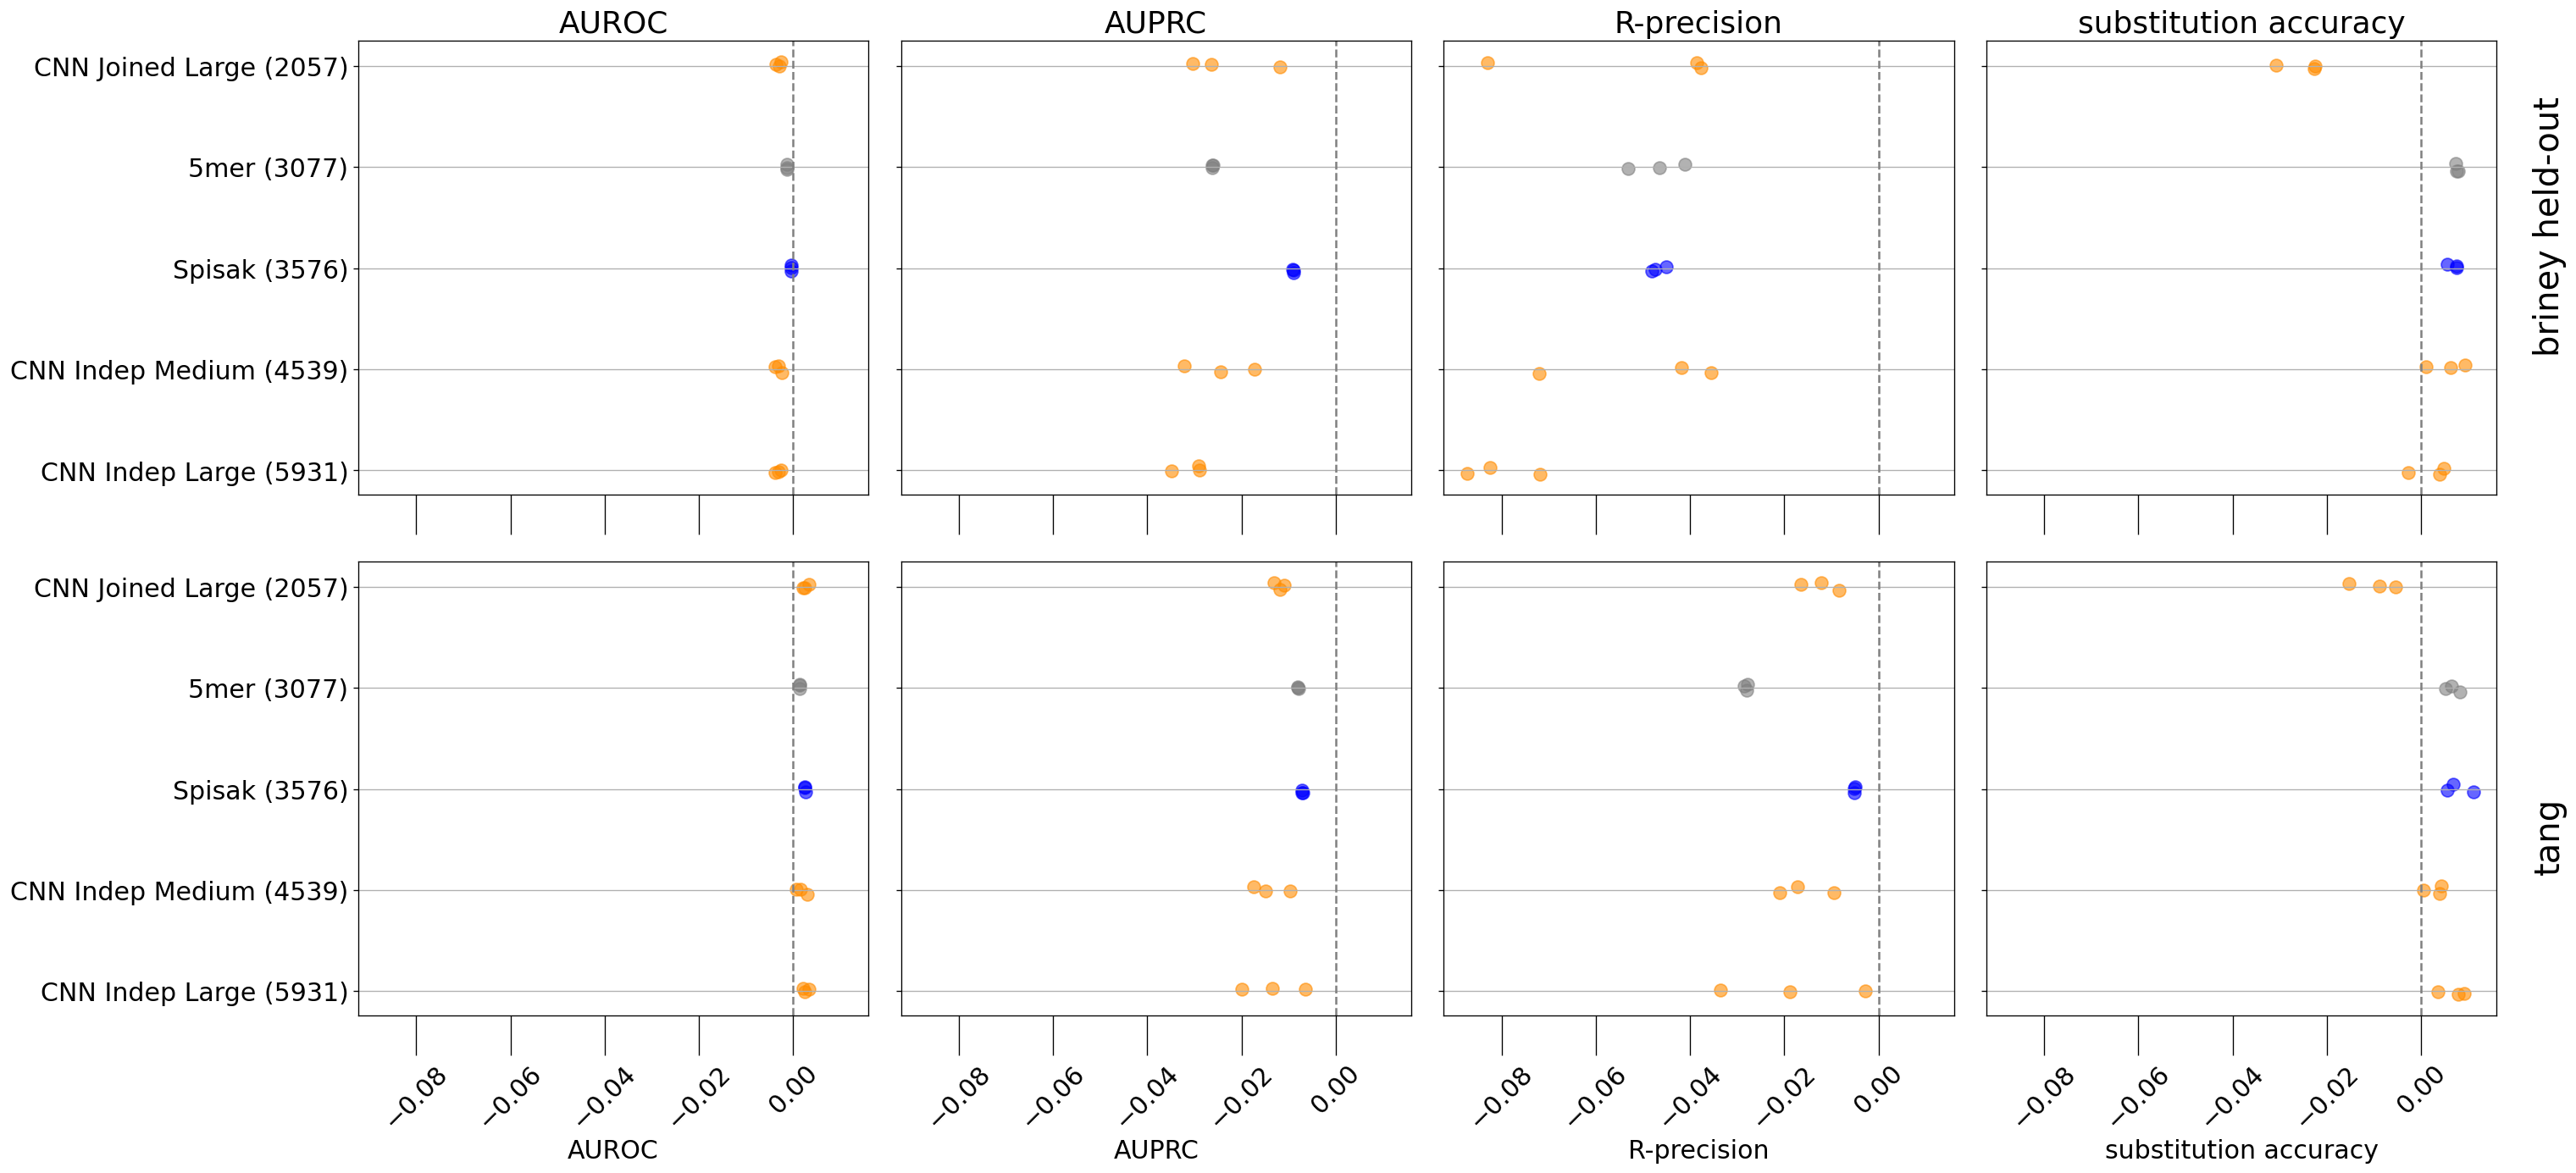

In [5]:
grouped_by_training = df.groupby("train dataset")

data_columns = ["AUROC", "AUPRC", "r-prec", "sub_acc"]
label_columns = ["model", "seed", "long_name", "test dataset", "parameter_count"]

# Extract the two groups
oof_train = grouped_by_training.get_group("shmoof_notbig").set_index(label_columns)
combo_train = grouped_by_training.get_group("shmoof_notbig+syn10x").set_index(label_columns)

# Ensure both groups are aligned based on the label columns
aligned_oof_train, aligned_combo_train = oof_train.align(combo_train)

# Subtract the data_columns while preserving the label_columns
#difference = aligned_combo_train[data_columns] - aligned_oof_train[data_columns]
difference = (aligned_combo_train[data_columns] - aligned_oof_train[data_columns]) / aligned_oof_train[data_columns]

# Reset the index to bring label_columns back as regular columns
difference = difference.reset_index()

plot_performance(difference, stats=prediction_stats, test_datasets=primary_test_datasets, include_baseline=False, plotting_difference=True, filename="performance_train_shmoof_notbig_syn_worse")